<a href="https://colab.research.google.com/github/AtulBha/WS-SPARK---Coding-Challange/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install geopandas

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

spark = SparkSession.builder.master('local').getOrCreate()

url = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/DataSample.csv"
url2 = "https://raw.githubusercontent.com/EQWorks/ws-data-spark/master/data/POIList.csv"
spark.sparkContext.addFile(url)
spark.sparkContext.addFile(url2)


df = spark.read.csv(SparkFiles.get("DataSample.csv"), header=True, inferSchema= True)
poi = spark.read.csv(SparkFiles.get("POIList.csv"), header=True, inferSchema= True)
poi_df = poi.toPandas()

In [6]:
df.printSchema()

root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [7]:
display(df.columns)
df = df.withColumnRenamed(' TimeSt', 'TimeSt')
display(df.columns)

['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

['_ID', 'TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']

In [8]:
poi_df.rename(columns={' Latitude': 'Latitude'}, inplace=True)

# 1. Cleanup

In [9]:
df.persist()  # the dataset is relatively small

DataFrame[_ID: int, TimeSt: string, Country: string, Province: string, City: string, Latitude: double, Longitude: double]

In [10]:
display(df.count())
df = df.dropDuplicates(["Latitude", "Longitude", "TimeSt"])
df.count()

22025

19999

In [11]:
df.show(5)

+-------+--------------------+-------+--------+----------+--------+---------+
|    _ID|              TimeSt|Country|Province|      City|Latitude|Longitude|
+-------+--------------------+-------+--------+----------+--------+---------+
|4520345|2017-06-21 22:00:...|     CA|      ON|   Windsor| 42.2654| -83.0261|
|5156965|2017-06-21 22:44:...|     CA|      ON|    London| 42.9334| -81.2258|
|5278748|2017-06-21 16:54:...|     CA|      ON|    London|42.98761|-81.25129|
|4576469|2017-06-21 06:02:...|     CA|      ON|   Grimsby| 43.1976| -79.5756|
|5081522|2017-06-21 18:39:...|     CA|      ON|Burlington| 43.3889| -79.7682|
+-------+--------------------+-------+--------+----------+--------+---------+
only showing top 5 rows



In [12]:
poi_df.drop_duplicates(["Latitude", "Longitude"], inplace=True)

In [13]:
poi_df.loc[2:,['POIID']] = ['POI2', 'POI3']
poi_df.reset_index(inplace=True, drop=True)

# 2. Label

In [14]:
poi_df

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,45.521629,-73.566024
2,POI3,45.224830,-63.232729


It is important to note that Euclidean distance is calculated on a cartesian plane. Since we are dealing with geographic data we also need to consider elevation or adjust the Euclidean formula. However, in order to answer Q3. and plot the circle we use Euclidean distance (2D). A more in-depth topic to consider is spatial relation (https://en.wikipedia.org/wiki/Spatial_relation)

In [15]:
from pyspark.sql.functions import pandas_udf
from scipy.spatial import distance
from geopy.distance import distance as geopy_distance
import pandas as pd
import numpy as np



def label_geoClass(lat, long, distFunc):

  @pandas_udf("class string, minDist float")
  def label_udf(lat: pd.Series, long: pd.Series) -> pd.DataFrame:
    lat_long = np.column_stack((lat, long))
    #lat_long = pd.DataFrame({'Latitude' : lat, 'Longitude': long})

    distances = distance.cdist(lat_long,
                               poi_df[['Latitude', 'Longitude']].values,
                               distFunc)
    
    class_labels = poi_df.iloc[distances.argmin(axis=1), 0]
    min_distances = distances.min(axis=1)
      
    return pd.DataFrame({'class': class_labels, 'minDist': min_distances})
  
  return label_udf(lat, long)
  

distFunc = 'euclidean'  #lambda u, v: geopy_distance(u, v).km
df = df.withColumn("class_minDist",  label_geoClass('Latitude', 'Longitude', distFunc))

In [16]:
temp = df.toPandas()
temp['geoClass'] = temp.class_minDist.map(lambda x: x['class'])
temp['minDist'] = temp.class_minDist.map(lambda x: x['minDist'])

# 3. Analysis

In [17]:
from pyspark.sql import functions as F

summary = df.groupBy('class_minDist.class')\
            .agg(F.avg('class_minDist.minDist').alias('Avg Min Distance'),
                F.stddev('class_minDist.minDist').alias('STD'),
                F.count('*').alias('NumObs'),
                F.max('class_minDist.minDist').alias('Radius'))\
            .orderBy('Avg Min Distance')\
            .withColumnRenamed('class_minDist.class', 'geoClass')\
            .toPandas()

summary = summary.merge(poi_df, left_on='geoClass', right_on='POIID').drop('POIID', axis=1)

summary['Density'] = summary.NumObs / (np.pi*(summary.Radius**2))
summary

,geoClass,Avg Min Distance,STD,NumObs,Radius,Latitude,Longitude,Density
0,POI1,3.348183,3.85849,9698,24.851936,53.546167,-113.485734,4.998179
1,POI2,5.537951,2.85869,9817,20.155378,45.521629,-73.566024,7.692136
2,POI3,8.810411,28.67513,484,192.704987,45.224830,-63.232729,0.004149


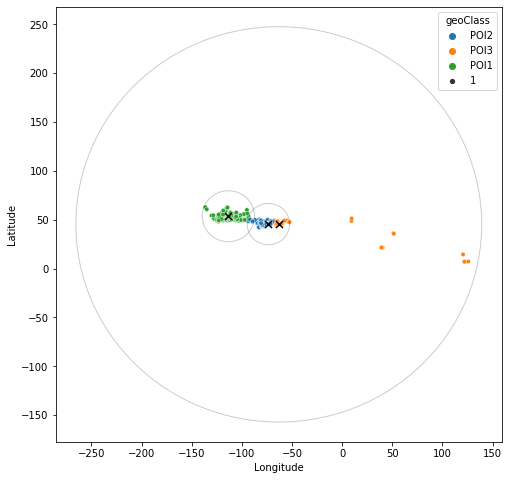

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=temp, x="Longitude", y="Latitude", hue="geoClass",
                     size=1)

def encircle(x, y, r, center, ax=ax, **kw):
    
    p = np.column_stack([x,y])
    #mean = np.mean(p, axis=0)
    #d = p-mean
    #r = np.max(np.sqrt(d[:,0]**2+d[:,1]**2 ))
    #circ = plt.Circle(mean, radius=1.05*r,**kw)
    circ = plt.Circle(center, radius=1.05*r,**kw)
    ax.add_patch(circ)

for data in summary.itertuples():
  ax.scatter(data.Longitude,data.Latitude, s=50, marker='x', color='black')
  encircle(temp[temp.geoClass == data.geoClass].Longitude,
           temp[temp.geoClass == data.geoClass].Latitude,
           r=data.Radius,
           center=np.array([data.Longitude, data.Latitude]),
           ec="k", fc="none", alpha=0.2)

plt.gca().relim()
plt.gca().autoscale_view()
plt.show()

# 4a i). Outlier detection & Custom Scaling

#### Outlier detection

In [19]:
outliers = dict()
for poi in summary.itertuples():
  poi_mean, poi_std = poi._2, poi.STD
  cut_off = poi_std * 3
  lower, upper = poi_mean - cut_off, poi_mean + cut_off
  outliers[poi.geoClass] = temp.loc[(temp.geoClass == poi.geoClass) &
                                    ((temp.minDist < lower) | (temp.minDist > upper)),
                                    ['minDist']].index

In [20]:
'|'.join(poi + ':' + str(len(outliers)) if len(outliers) else poi + ':' + str(0)
         for poi,outliers in outliers.items())  # outliers present in POI

'POI1:281|POI2:213|POI3:20'

#### Scaled (-10,10) with Robust Scaling

count    19999.000000
mean        -9.527762
std          0.593584
min        -10.000000
25%         -9.780023
50%         -9.606983
75%         -9.339771
max         10.000000
Name: minDist_Scaled, dtype: float64

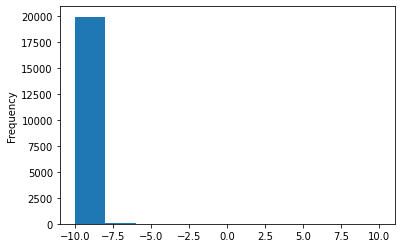

In [21]:
# Robust scaling is insensitive to outliers
# Ref: https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
# Rescale: https://stats.stackexchange.com/a/25897

def robust_scale(X):
  
  X_max = X.quantile(q=0.75)
  X_min = X.quantile(q=0.25)
  X_norm = (X - X.median()) / (X_max - X_min)

  #X_norm_max = X_norm.max()
  #X_norm_min = X_norm.min()
  #X_scaled = (X_norm - X_norm_min) / (X_norm_max - X_norm_min)

  #new_scale_max = 10
  #new_scale_min = -10
  #X_reScaled = X_scaled * (new_scale_max - new_scale_min) + new_scale_min

  #return X_reScaled

  X_norm_max = X_norm.max()
  X_norm_min = X_norm.min()
  new_scale_max = 10
  new_scale_min = -10
  X_scaled = (X_norm - X_norm_min) * ((new_scale_max - new_scale_min)/ (X_norm_max - X_norm_min)) + new_scale_min

  return X_scaled

temp['minDist_Scaled'] = temp.minDist.transform(robust_scale)
display(temp.minDist_Scaled.describe())
temp.minDist_Scaled.plot(kind='hist')

#### Visualize POI variance and distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

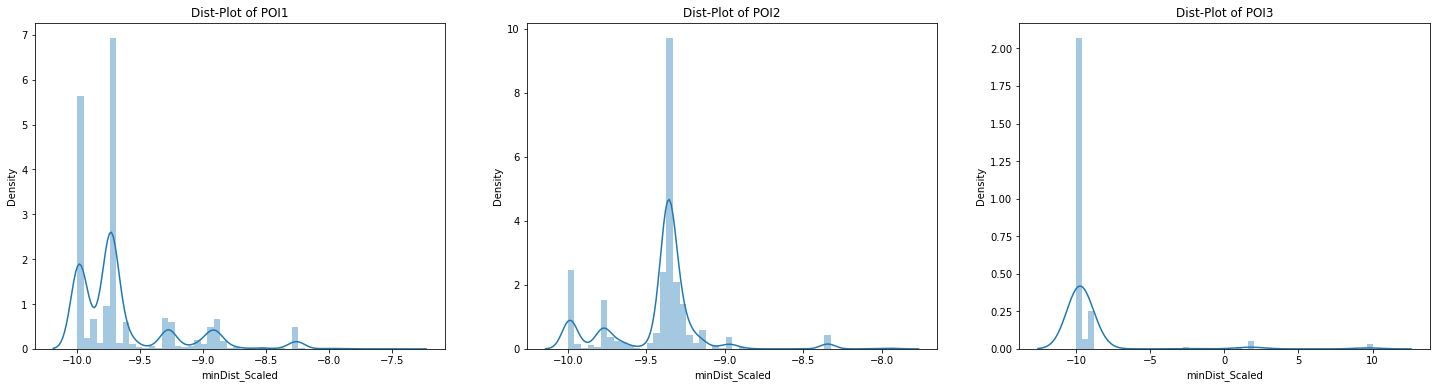

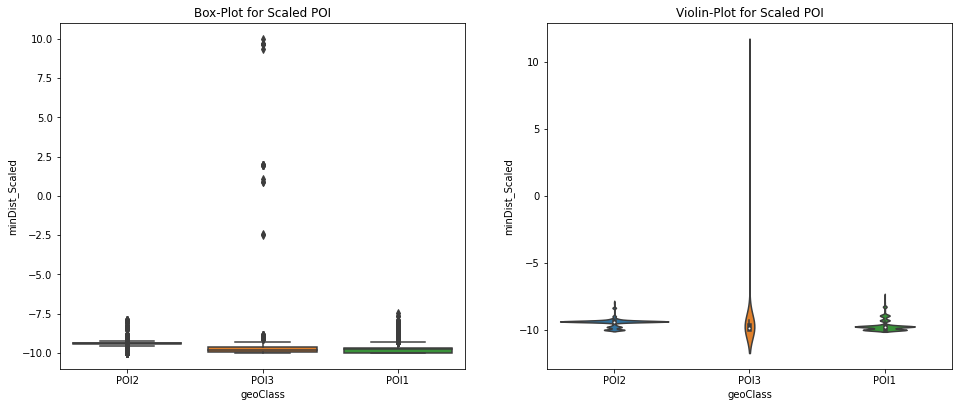

In [22]:
plt.figure(figsize=(25,6))
for i, row in enumerate(summary.itertuples(), 1):
  plt.subplot(1,summary.shape[0],i)
  sns.distplot(temp.loc[temp.geoClass == row.geoClass,'minDist_Scaled'])
  plt.title("Dist-Plot of {}".format(row.geoClass))
plt.show()

plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
sns.boxplot(x='geoClass', y='minDist_Scaled', data=temp)
plt.title("Box-Plot for Scaled POI")

plt.subplot(2,2,2)
sns.violinplot(x='geoClass', y='minDist_Scaled', data=temp)
plt.title("Violin-Plot for Scaled POI")
plt.show()

# 4a ii). Insights from Data

In [23]:
temp['TimeSt'] = pd.to_datetime(temp.TimeSt)

((5, 811), (1, 919))

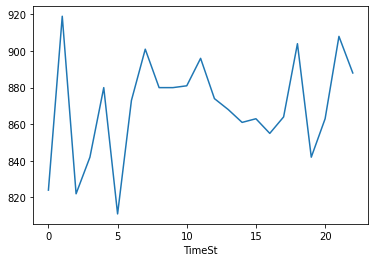

In [24]:
cnts = temp.groupby(temp.TimeSt.dt.hour)['_ID'].count()
cnts.plot()
min_idx, max_idx = cnts.idxmin(), cnts.idxmax()
(min_idx, cnts[min_idx]), (max_idx, cnts[max_idx])

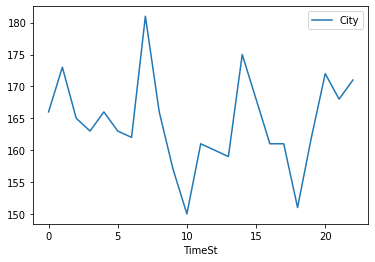

In [25]:
unique_city_activity = temp.groupby(temp.TimeSt.dt.hour).agg({'City': 'nunique'})
unique_city_activity.plot()
# 7-7:59 Highest Activity, 10-10:59 Lowest Activity from unique cities
# However, it generally follows the same trend as above

In [26]:
city_activity_freq = temp.City.value_counts()
major_activity_cities = city_activity_freq[city_activity_freq > (unique_city_activity.mean().values[0])]
(major_activity_cities.shape[0] / city_activity_freq.shape[0]) * 100
# Most of the activity comes from about top 3.35 % of cities

3.353658536585366

In [27]:
city_activity_freq[ city_activity_freq == city_activity_freq.quantile(q=0.01)].shape[0]
# Bottom Cities

243

# 4b) Pipeline Dependency

## Solution

In [34]:
from collections import deque

def shortestPathBFS(graph, startNode, endNode):
    queue = deque()
    queue.append(endNode)
    nodes_parents = {str(endNode): None}
    completed_tasks = set()

    for task in startNode:  # Dependencies for starting tasks are completed
      completed_depends = graph[task]
      for cd in completed_depends:
        completed_tasks.add(cd)

    while queue:
        curTask = queue.popleft()
        
        dependencies = graph[curTask]
        to_do_tasks = (dependencies - nodes_parents.keys()) - completed_tasks

        for task in to_do_tasks:
            queue.append(task)
            nodes_parents[str(task)] = curTask

    print ('->'.join(list(nodes_parents.keys())[::-1]))

Test Cases

In [35]:
from collections import defaultdict

relations = '''A->C
B->C
C->E
E->F'''

graph = defaultdict(list)
for pair in relations.split('\n'):
  v,k = pair.split('->')
  graph[k].append(v)

graph

#TC 1
starting_tasks = {'A'}
goal_task = 'F'
shortestPathBFS(graph, starting_tasks, goal_task)

#TC 2
starting_tasks = {'A', 'C'}
shortestPathBFS(graph, starting_tasks, goal_task)

B->A->C->E->F
C->E->F


## Final Submission

In [36]:
!wget -q https://gist.githubusercontent.com/woozyking/f1d50e1fe1b3bf52e3748bc280cf941f/raw/2d582e0b6d2a55bd50289b4fb2889f321693e288/relations.txt

relations = pd.read_csv('relations.txt', header=None, sep=r'->', names=['Dependency', 'Task'], engine='python')
relations.head(2) 

,Dependency,Task
0,97,102
1,75,31


In [63]:
!wget -q https://gist.githubusercontent.com/woozyking/f1d50e1fe1b3bf52e3748bc280cf941f/raw/2d582e0b6d2a55bd50289b4fb2889f321693e288/task_ids.txt

reverse_graph = dict()
with open('task_ids.txt', 'r') as f:
  for task_id in f.readline().split(','):
    reverse_graph[int(task_id)] = []

for row in relations.itertuples():
  reverse_graph[row.Task].append(row.Dependency)
reverse_graph  # Note that this is a reversed graph or indegree graph where values are all nodes pointing to the key node

{16: [],
 20: [100, 21, 73],
 21: [],
 31: [75, 102, 55],
 36: [102],
 37: [75, 102, 16, 55],
 39: [],
 41: [],
 55: [62, 56],
 56: [94],
 62: [],
 73: [39, 41],
 75: [56],
 94: [20],
 97: [112, 20],
 100: [39],
 102: [97, 56, 94],
 112: [41]}

In [64]:
starting_tasks = {73}
goal_task = 36
shortestPathBFS(reverse_graph, starting_tasks, goal_task)

21->100->73->20->112->94->97->56->102->36


---
### **topological_sort**

In [88]:
graph = dict()
with open('task_ids.txt', 'r') as f:
  for task_id in f.readline().split(','):
    graph[int(task_id)] = []

for row in relations.itertuples():
  graph[row.Dependency].append(row.Task)
graph

{16: [37],
 20: [94, 97],
 21: [20],
 31: [],
 36: [],
 37: [],
 39: [73, 100],
 41: [73, 112],
 55: [31, 37],
 56: [102, 75, 55],
 62: [55],
 73: [20],
 75: [31, 37],
 94: [56, 102],
 97: [102],
 100: [20],
 102: [36, 37, 31],
 112: [97]}

In [93]:
from collections import deque, defaultdict

def topological_sort(graph, startNode, endNode):
    
    indegrees = defaultdict(lambda: 0)     # node: # of incoming edges
    for node, neighbours in graph.items():
      for neighbour in neighbours:
        indegrees[neighbour] += 1  # add one incoming edge

    node_with_no_incoming_edges = deque()  #deque([startNode]) if startNode else 
    for node in graph.keys():
      if indegrees[node] == 0:     # no incoming edges
        node_with_no_incoming_edges.append(node)  # [16, 39, 41, 62, 21]

    topological_ordering = []

    while len(node_with_no_incoming_edges) > 0:

      curNode = node_with_no_incoming_edges.popleft()
      topological_ordering.append(str(curNode))
      #print(topological_ordering)

      for neighbour in graph[curNode]:
        indegrees[neighbour] -= 1
        if indegrees[neighbour] == 0:
          #if neighbour == endNode:
          #  topological_ordering.append(str(curNode))
          #  return '->'.join(topological_ordering)
          node_with_no_incoming_edges.append(neighbour)

    return ('->'.join(topological_ordering))

In [94]:
starting_tasks = 73
goal_task = 36

topological_sort(graph, starting_tasks, goal_task) 

'16->39->41->62->21->100->73->112->20->94->97->56->102->75->55->36->31->37'

The question asks for topological sorting, however, this is incorrect way to answer the problem. In topological sort, we end up adding extra nodes that have indegree of 0 in the subsequence starNode to endNode. Always it is not obvious what is the starting cutoff point (it may not be startNode) 